# Deep Learning

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
import optuna
import plotly
import tensorflow as tf
import random
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from optuna.integration import TFKerasPruningCallback
from optuna.visualization import plot_optimization_history, plot_param_importances


# Create a logger instance
logger = logging.getLogger(
    __name__
)

# Set the logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
logger.setLevel(logging.INFO)

# Create a handler
handler = logging.StreamHandler()

# Format the logs to include level, module name, and message
formatter = logging.Formatter("[%(levelname)s] %(name)s - %(message)s")
handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(handler)

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

plt.rcParams["figure.figsize"] = [10, 6]

## Data Preparation

In [3]:
# Load the data
merged_df = (
    pd.read_csv(
        "../data/merged_df.csv", parse_dates=["timestamp"], index_col="timestamp"
    )
    .sort_index()
    .convert_dtypes()
)
arima_predictions_T = (pd.read_csv('../data/arima_predictions_T.csv', parse_dates=['timestamp'], index_col='timestamp')
                       .sort_index()
                       .convert_dtypes())
arima_predictions_V = (pd.read_csv('../data/arima_predictions_VZ.csv', parse_dates=['timestamp'], index_col='timestamp')
                       .sort_index()
                       .convert_dtypes())

In [4]:
merged_df.head(10)

,close_t,close_v,weekday_name,market_holiday,t_diff,v_diff
timestamp,,,,,,
2019-01-02,29.54,56.02,Wednesday,False,0.0,0.0
2019-01-03,29.58,56.22,Thursday,False,0.04,0.2
2019-01-04,30.34,56.36,Friday,False,0.76,0.14
2019-01-05,30.34,56.36,Saturday,False,0.0,0.0
2019-01-06,30.34,56.36,Sunday,False,0.0,0.0
2019-01-07,30.89,56.72,Monday,False,0.55,0.36
2019-01-08,31.28,58.38,Tuesday,False,0.39,1.66
2019-01-09,30.1,57.05,Wednesday,False,-1.18,-1.33
2019-01-10,30.4,57.6,Thursday,False,0.3,0.55


In [5]:
# Feature scaling
scaler_t = MinMaxScaler(feature_range=(0, 1))
scaler_v = MinMaxScaler(feature_range=(0, 1))

# Reshape data to 2D arrays as required by MinMaxScaler
merged_df["t_scaled"] = scaler_t.fit_transform(
    merged_df["t_diff"].values.reshape(-1, 1)
)
merged_df["v_scaled"] = scaler_v.fit_transform(
    merged_df["v_diff"].values.reshape(-1, 1)
)

In [28]:
merged_df.t_scaled.head()

timestamp
2019-01-02    0.503949
2019-01-03    0.510269
2019-01-04    0.624013
2019-01-05    0.503949
2019-01-06    0.503949
Name: t_scaled, dtype: float64

In [6]:
# Create separate datasets out of the time series.
t_data = merged_df['t_scaled'].values
v_data = merged_df['v_scaled'].values

# Make sure we can use the same split point for both datasets
assert len(t_data) == len(v_data)

# Creating split points to maintain temporal integrity
split_point = int(len(t_data) * 0.95)

t_train_data, t_test_data = t_data[:split_point], t_data[split_point:]
v_train_data, v_test_data = v_data[:split_point], v_data[split_point:]


In [7]:
# Create a function to split the dataset into sub-sequences
def create_dataset(data: np.ndarray, window_size: int) -> tuple:
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)


In [8]:
# Reshape the data
n_steps = 10
n_features = 1

t_X_train, t_y_train = create_dataset(t_train_data, n_steps)
t_X_train = t_X_train.reshape(t_X_train.shape[0], t_X_train.shape[1], n_features)

t_X_test, t_y_test = create_dataset(t_test_data, n_steps)
t_X_test = t_X_test.reshape(t_X_test.shape[0], t_X_test.shape[1], n_features)

v_X_train, v_y_train = create_dataset(v_train_data, n_steps)
v_X_train = v_X_train.reshape(v_X_train.shape[0], v_X_train.shape[1], n_features)

v_X_test, v_y_test = create_dataset(v_test_data, n_steps)
v_X_test = v_X_test.reshape(v_X_test.shape[0], v_X_test.shape[1], n_features)


In [32]:
print(t_X_train.shape, t_y_train.shape)
print(v_X_train.shape, v_y_train.shape)

(827, 10, 1) (827,)
(827, 10, 1) (827,)


## Implementing an RNN model
### AT&T Stock Price Prediction

In [33]:
def objective(trial):
    # Define the hyperparameter search space
    n_units = trial.suggest_int("n_units", 20, 200)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    window_size = trial.suggest_int("window_size", 5, 30)

    # Re-create the dataset with the current window_size
    X_train, y_train = create_dataset(t_train_data, window_size)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    X_val, y_val = create_dataset(t_test_data, window_size)
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # Build the model
    model = Sequential()
    model.add(SimpleRNN(units=n_units, activation="tanh", input_shape=(window_size, 1)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1))

    # Compile the model
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mean_squared_error")

    # Define Early Stopping
    early_stop = EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, TFKerasPruningCallback(trial, "val_loss")],
        verbose=0,  # Suppress training output for cleaner Optuna logs
    )

    # Evaluate the model on validation data
    val_loss = history.history["val_loss"][-1]

    return val_loss

In [ ]:
warnings.filterwarnings("ignore")

# Create the Optuna study
study = optuna.create_study(
    direction="minimize", study_name="SimpleRNN Hyperparameter Optimization"
)
study.optimize(
    objective, n_trials=50, timeout=600
)  # Adjust n_trials and timeout as needed

# Display the best trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-01-17 15:36:45,094] A new study created in memory with name: SimpleRNN Hyperparameter Optimization


2025-01-17 15:36:45.310679: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
[I 2025-01-17 15:36:56,896] Trial 0 finished with value: 0.008349504321813583 and parameters: {'n_units': 189, 'dropout_rate': 0.4370581922762573, 'learning_rate': 0.007369712152728976, 'batch_size': 16, 'window_size': 29}. Best is trial 0 with value: 0.008349504321813583.
[I 2025-01-17 15:36:59,074] Trial 1 finished with value: 0.005865920800715685 and parameters: {'n_units': 143, 'dropout_rate': 0.4403194483045942, 'learning_rate': 1.3202711470495564e-05, 'batch_size': 16, 'window_size': 17}. Best is trial 1 with value: 0.005865920800715685.
[I 2025-01-17 15:37:05,926] Trial 2 finished with value: 0.008603308349847794 and parameters: {'n_units': 185, 'dropout_rate': 0.1537412990288563, 'learning_rate': 0.001803095931849199, 'batch_size': 32, 'window_size': 27}. Best is trial 1 with value: 0.005865920800715685.
[I 2025-01-17 15:37:07,605] Trial 3 finished with value:

[I 2025-01-17 15:37:15,496] Trial 9 finished with value: 0.006715416442602873 and parameters: {'n_units': 144, 'dropout_rate': 0.08367337509332862, 'learning_rate': 0.0001773412111813362, 'batch_size': 16, 'window_size': 13}. Best is trial 4 with value: 0.005820725578814745.
[I 2025-01-17 15:37:16,008] Trial 10 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:16,567] Trial 11 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:17,089] Trial 12 pruned. Trial was pruned at epoch 0.


[I 2025-01-17 15:37:17,619] Trial 13 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:18,185] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:18,704] Trial 15 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:19,227] Trial 16 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:20,366] Trial 17 finished with value: 0.004113285336643457 and parameters: {'n_units': 137, 'dropout_rate': 0.22197095719080398, 'learning_rate': 2.471515404024836e-05, 'batch_size': 32, 'window_size': 8}. Best is trial 17 with value: 0.004113285336643457.
[I 2025-01-17 15:37:20,881] Trial 18 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:21,629] Trial 19 pruned. Trial was pruned at epoch 0.
[I 2025-01-17 15:37:22,728] Trial 20 finished with value: 0.005505301058292389 and parameters: {'n_units': 115, 'dropout_rate': 0.15402832381138518, 'learning_rate': 0.0003831487823387726, 'batch_size': 32, 'window_size': 8}. Best is trial 17 with value: 0.004113285336643457.
[I

Number of finished trials:  50
Best trial:
  Value: 0.004113285336643457
  Params: 
    n_units: 137
    dropout_rate: 0.22197095719080398
    learning_rate: 2.471515404024836e-05
    batch_size: 32
    window_size: 8


In [35]:
# Retrieve best hyperparameters
best_params = study.best_trial.params

# Extract hyperparameters
best_n_units = best_params["n_units"]
best_dropout_rate = best_params["dropout_rate"]
best_learning_rate = best_params["learning_rate"]
best_batch_size = best_params["batch_size"]
best_window_size = best_params["window_size"]

# Prepare the dataset with the best window size
X_train_best, y_train_best = create_dataset(t_train_data, best_window_size)
X_train_best = X_train_best.reshape((X_train_best.shape[0], X_train_best.shape[1], 1))

X_val_best, y_val_best = create_dataset(t_test_data, best_window_size)
X_val_best = X_val_best.reshape((X_val_best.shape[0], X_val_best.shape[1], 1))

# Build the final model with best hyperparameters
final_model = Sequential()
final_model.add(
    SimpleRNN(units=best_n_units, activation="tanh", input_shape=(best_window_size, 1))
)
final_model.add(Dropout(rate=best_dropout_rate))
final_model.add(Dense(1))

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=best_learning_rate)
final_model.compile(optimizer=optimizer, loss="mean_squared_error")

# Define Early Stopping
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the final model
history = final_model.fit(
    X_train_best,
    y_train_best,
    epochs=100,
    batch_size=best_batch_size,
    validation_data=(X_val_best, y_val_best),
    callbacks=[early_stop],
    verbose=1,
)

# Evaluate the final model
test_loss = final_model.evaluate(X_val_best, y_val_best)
print(f"Final Model Test Mean Squared Error: {test_loss}")

Epoch 1/100
26/26 [==============================] - 0s 6ms/step - loss: 0.0746 - val_loss: 0.0106
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0073
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0069
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0207 - val_loss: 0.0070
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0205 - val_loss: 0.0070
Epoch 6/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0186 - val_loss: 0.0070
Epoch 7/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0184 - val_loss: 0.0070
Epoch 8/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0174 - val_loss: 0.0071
Epoch 9/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0163 - val_loss: 0.0071
Epoch 10/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0071
Epoch 11/

2/2 [==============================] - 0s 1ms/step


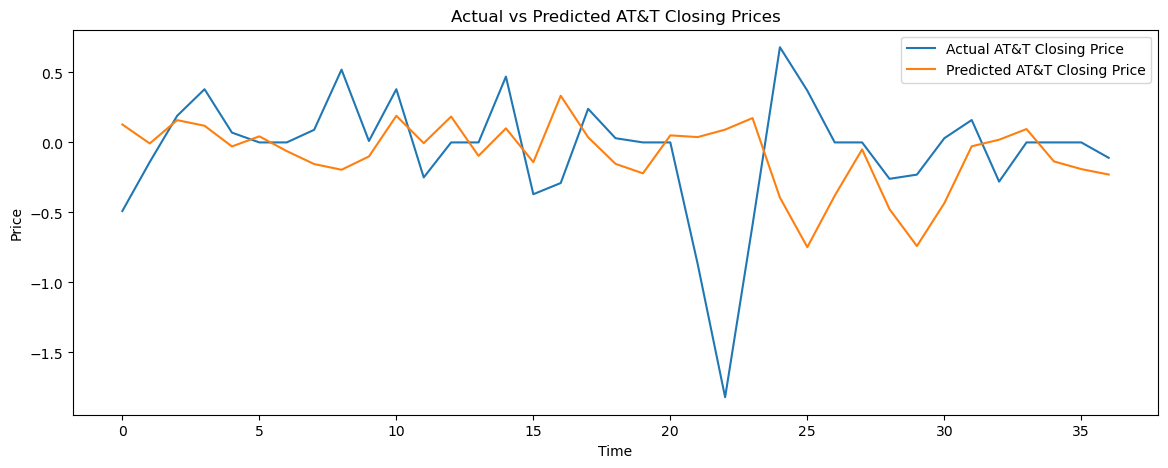

In [36]:
# Make predictions on test data
y_pred_best = final_model.predict(X_val_best)

# Inverse transform the scaled data
t_y_test_actual = scaler_t.inverse_transform(y_val_best.reshape(-1, 1))
t_y_pred_actual = scaler_t.inverse_transform(y_pred_best)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(t_y_test_actual, label="Actual AT&T Closing Price")
plt.plot(t_y_pred_actual, label="Predicted AT&T Closing Price")
plt.title("Actual vs Predicted AT&T Closing Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [25]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from typing import Optional, Tuple


def create_dataset(data: np.ndarray, window_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """Create a dataset with sequences of length `window_size` and the subsequent target value.

    Args:
        data (np.ndarray): 1D array of scaled time-series data.
        window_size (int): Number of time steps to include in each input sample.

    Returns:
        (X, y): A tuple of input samples (X) and targets (y).
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : (i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

logger = logging.getLogger(__name__)

class SimpleRNNModel:
    """A class to encapsulate the lifecycle of a SimpleRNN model, from data preprocessing and
    hyperparameter optimization to final training and prediction.

    Attributes:
        data (pd.Series): The raw time-series data, e.g., closing prices.
        n_steps (int): Initial window size to create input sequences. May be overridden by Optuna.
        n_features (int): Number of features per time step (usually 1 for univariate time series).
        name (str): Identifier for the model (e.g., 'AT&T', 'Verizon').
        scaler (MinMaxScaler): Scaler to normalize or standardize the data.
        data_scaled (Optional[np.ndarray]): The scaled version of `data`.
        train_data (Optional[np.ndarray]): The subset of `data_scaled` for training.
        test_data (Optional[np.ndarray]): The subset of `data_scaled` for testing.
        X_train_best (Optional[np.ndarray]): Final training inputs with best parameters.
        y_train_best (Optional[np.ndarray]): Final training labels with best parameters.
        X_val_best (Optional[np.ndarray]): Final validation inputs with best parameters.
        y_val_best (Optional[np.ndarray]): Final validation labels with best parameters.
        final_model (Optional[Sequential]): The final trained SimpleRNN model.
        history (Optional[tf.keras.callbacks.History]): Training history from final model training.
        test_loss (Optional[float]): Loss on the test/validation set after final training.
        best_params (dict): Dictionary storing best hyperparameters found by Optuna.
        best_n_units (Optional[int]): Best number of RNN units chosen by Optuna.
        best_dropout_rate (Optional[float]): Best dropout rate chosen by Optuna.
        best_learning_rate (Optional[float]): Best learning rate chosen by Optuna.
        best_batch_size (Optional[int]): Best batch size chosen by Optuna.
        best_window_size (Optional[int]): Best window size chosen by Optuna.
    """

    def __init__(
        self, data: pd.Series, n_steps: int, n_features: int, name: str
    ) -> None:
        """Constructor for SimpleRNNModel.

        Args:
            data (pd.Series): Univariate time-series data (e.g., daily closing prices).
            n_steps (int): Initial number of time steps for the window; used if not overridden by Optuna.
            n_features (int): Dimensionality of input features per time step.
            name (str): Name identifier for the model (e.g., 'AT&T').
        """
        self.data = data
        self.n_steps = n_steps
        self.n_features = n_features
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.name = name

        # Attributes that will be set later
        self.data_scaled: Optional[np.ndarray] = None
        self.train_data: Optional[np.ndarray] = None
        self.test_data: Optional[np.ndarray] = None
        self.X_train_best: Optional[np.ndarray] = None
        self.y_train_best: Optional[np.ndarray] = None
        self.X_val_best: Optional[np.ndarray] = None
        self.y_val_best: Optional[np.ndarray] = None
        self.final_model: Optional[Sequential] = None
        self.history: Optional[tf.keras.callbacks.History] = None
        self.test_loss: Optional[float] = None

        self.best_params: dict = {}
        self.best_n_units: Optional[int] = None
        self.best_dropout_rate: Optional[float] = None
        self.best_learning_rate: Optional[float] = None
        self.best_batch_size: Optional[int] = None
        self.best_window_size: Optional[int] = None

    def scale_split(self, split_ratio: float = 0.95) -> None:
        """Scale and split the dataset into train and test sets.

        Args:
            split_ratio (float, optional): Fraction of the data to use for training.
                The remainder is for testing. Defaults to 0.95.
        """
        # Scale the data
        self.data_scaled = self.scaler.fit_transform(self.data.values.reshape(-1, 1))

        # Split the data
        split_point = int(len(self.data_scaled) * split_ratio)
        self.train_data = self.data_scaled[:split_point]
        self.test_data = self.data_scaled[split_point:]

        # Log the data properties
        logger.info(f"Data has been scaled and split with a ratio of {split_ratio}.")
        logger.debug(f"Train data size: {len(self.train_data)}, Test data size: {len(self.test_data)}")

    def optimize(self, n_trials: int = 50, timeout: int = 600) -> None:
        """Use Optuna to find the best hyperparameters for the SimpleRNN model.

        Args:
            n_trials (int, optional): Number of hyperparameter trials. Defaults to 50.
            timeout (int, optional): Time (in seconds) after which the study will stop. Defaults to 600.
        """
        if self.train_data is None or self.test_data is None:
            logger.error("Optimization aborted: data not yet scaled/split.")
            raise ValueError(
                "Please run `scale_split()` before optimizing hyperparameters."
            )

        def objective(trial: optuna.trial.Trial) -> float:
            # Suggest hyperparameters
            n_units = trial.suggest_int("n_units", 20, 200)
            dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
            learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
            batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
            window_size = trial.suggest_int("window_size", 5, 30)

            # Create datasets with suggested window_size
            X_train, y_train = create_dataset(self.train_data, window_size)
            X_val, y_val = create_dataset(self.test_data, window_size)

            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
            X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

            # Build model
            model = Sequential()
            model.add(
                SimpleRNN(
                    units=n_units, activation="tanh", input_shape=(window_size, 1)
                )
            )
            model.add(Dropout(rate=dropout_rate))
            model.add(Dense(1))

            # Compile
            # I'm running an M1 Mac, so I need to use the legacy optimizer for now
            optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss="mean_squared_error")

            # Callbacks
            early_stop = EarlyStopping(
                monitor="val_loss", patience=10, restore_best_weights=True
            )

            # Train
            history = model.fit(
                X_train,
                y_train,
                epochs=100,
                batch_size=batch_size,
                validation_data=(X_val, y_val),
                callbacks=[early_stop, TFKerasPruningCallback(trial, "val_loss")],
                verbose=0,
            )

            # Last validation loss
            val_loss = history.history["val_loss"][-1]
            return val_loss

        warnings.filterwarnings("ignore")

        # Create a study and run optimization
        logger.info(f"Beginning Optuna hyperparameter optimization with {n_trials} trials.")
        study = optuna.create_study(
            direction="minimize",
            study_name=f"SimpleRNN_{self.name}_Hyperparameter_Optimization",
        )
        study.optimize(objective, n_trials=n_trials, timeout=timeout)

        # Best hyperparameters
        self.best_params = study.best_trial.params
        self.best_n_units = self.best_params["n_units"]
        self.best_dropout_rate = self.best_params["dropout_rate"]
        self.best_learning_rate = self.best_params["learning_rate"]
        self.best_batch_size = self.best_params["batch_size"]
        self.best_window_size = self.best_params["window_size"]

        logger.info(
            "Optuna optimization complete. Best value (val_loss): %f",
            study.best_trial.value,
        )
        logger.info("Best parameters found: %s", self.best_params)

        # Plot study results
        try:
            from optuna.visualization import (
                plot_optimization_history,
                plot_param_importances,
            )

            fig1 = plot_optimization_history(study)
            fig1.show()
            fig2 = plot_param_importances(study)
            fig2.show()
        except ImportError:
            print("Optuna visualization libraries not installed, skipping plots...")

    def train(self) -> None:
        """Train a final SimpleRNN model using the best hyperparameters determined by Optuna."""
        if any(
            param is None
            for param in [
                self.best_n_units,
                self.best_dropout_rate,
                self.best_learning_rate,
                self.best_batch_size,
                self.best_window_size,
            ]
        ):
            logger.error("Cannot train final model: hyperparameters not set.")
            raise ValueError("Hyperparameters not set. Please run `optimize()` first.")

        # Recreate dataset with best window size
        self.X_train_best, self.y_train_best = create_dataset(
            self.train_data, self.best_window_size
        )
        self.X_val_best, self.y_val_best = create_dataset(
            self.test_data, self.best_window_size
        )

        self.X_train_best = self.X_train_best.reshape(
            (self.X_train_best.shape[0], self.X_train_best.shape[1], 1)
        )
        self.X_val_best = self.X_val_best.reshape(
            (self.X_val_best.shape[0], self.X_val_best.shape[1], 1)
        )

        # Build final model
        self.final_model = Sequential()
        self.final_model.add(
            SimpleRNN(
                units=self.best_n_units,
                activation="tanh",
                input_shape=(self.best_window_size, 1),
            )
        )
        self.final_model.add(Dropout(rate=self.best_dropout_rate))
        self.final_model.add(Dense(1))

        # Compile
        optimizer = tf.keras.optimizers.legacy.Adam(
            learning_rate=self.best_learning_rate
        )
        self.final_model.compile(optimizer=optimizer, loss="mean_squared_error")

        # Callbacks
        early_stop = EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        )

        # Train final model
        logger.info(f"Training final {self.name} model with best hyperparameters...")
        self.history = self.final_model.fit(
            self.X_train_best,
            self.y_train_best,
            epochs=100,
            batch_size=self.best_batch_size,
            validation_data=(self.X_val_best, self.y_val_best),
            callbacks=[early_stop],
            verbose=1,
        )

        # Evaluate on validation set
        self.test_loss = self.final_model.evaluate(
            self.X_val_best, self.y_val_best, verbose=0
        )
        logger.info(f"Final model training complete. Validation loss: {self.test_loss:.6f}")

    def plot_loss(self) -> None:
        """Plot the training and validation loss over epochs to visualize model performance."""
        if not self.history:
            logger.error("Cannot plot loss: no training history found.")
            raise ValueError(
                "No training history found. Run `train()` before plotting loss."
            )

        plt.figure(figsize=(10, 5))
        plt.plot(self.history.history["loss"], label="Training Loss")
        plt.plot(self.history.history["val_loss"], label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"{self.name} Training and Validation Loss")
        plt.legend()
        plt.show()

    def predict(self) -> None:
        """Generate predictions using the trained model and store them for later plotting or analysis."""
        if not self.final_model:
            logger.error("Cannot make predictions: final model not trained.")
            raise ValueError("Model not trained. Run `train()` before prediction.")

        logger.info("Generating predictions for validation set...")
        self.y_pred_best = self.final_model.predict(self.X_val_best)

    def plot_predictions(self) -> None:
        """Plot the actual vs predicted values for the final model."""
        if not hasattr(self, "y_pred_best"):
            logger.error("No predictions to plot. Did you run `predict()`?")
            raise ValueError(
                "No predictions found. Run `predict()` before plotting predictions."
            )

        # Inverse transform
        y_val_actual = self.scaler.inverse_transform(self.y_val_best.reshape(-1, 1))
        y_pred_actual = self.scaler.inverse_transform(self.y_pred_best)

        plt.figure(figsize=(14, 5))
        plt.plot(y_val_actual, label=f"Actual {self.name} Closing Price")
        plt.plot(y_pred_actual, label=f"Predicted {self.name} Closing Price")
        plt.title(f"Actual vs Predicted {self.name} Closing Prices")
        plt.xlabel("Time Steps")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

[I 2025-01-18 08:40:36,528] A new study created in memory with name: SimpleRNN_AT&T_Hyperparameter_Optimization
[I 2025-01-18 08:40:39,033] Trial 0 finished with value: 0.008860631845891476 and parameters: {'n_units': 171, 'dropout_rate': 0.2345439868962837, 'learning_rate': 0.006914299713611399, 'batch_size': 32, 'window_size': 25}. Best is trial 0 with value: 0.008860631845891476.
[I 2025-01-18 08:40:40,501] Trial 1 finished with value: 0.0060951667837798595 and parameters: {'n_units': 49, 'dropout_rate': 0.37301608633338545, 'learning_rate': 0.0032466774879504664, 'batch_size': 64, 'window_size': 17}. Best is trial 1 with value: 0.0060951667837798595.
[I 2025-01-18 08:40:44,301] Trial 2 finished with value: 0.006126015912741423 and parameters: {'n_units': 175, 'dropout_rate': 0.06364874459259529, 'learning_rate': 0.0003504914097383055, 'batch_size': 128, 'window_size': 11}. Best is trial 1 with value: 0.0060951667837798595.
[I 2025-01-18 08:40:45,998] Trial 3 finished with value: 0.

Number of finished trials: 50
Best trial:
  Value (val_loss): 0.005147928837686777
  Params:
    n_units: 66
    dropout_rate: 0.2349417796509913
    learning_rate: 0.0014710620232520769
    batch_size: 16
    window_size: 7


Epoch 1/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0440 - val_loss: 0.0053
Epoch 2/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0050
Epoch 3/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0087 - val_loss: 0.0054
Epoch 4/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 5/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0081
Epoch 6/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 7/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0054
Epoch 8/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0056
Epoch 9/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0055
Epoch 10/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0067
Epoch 11/

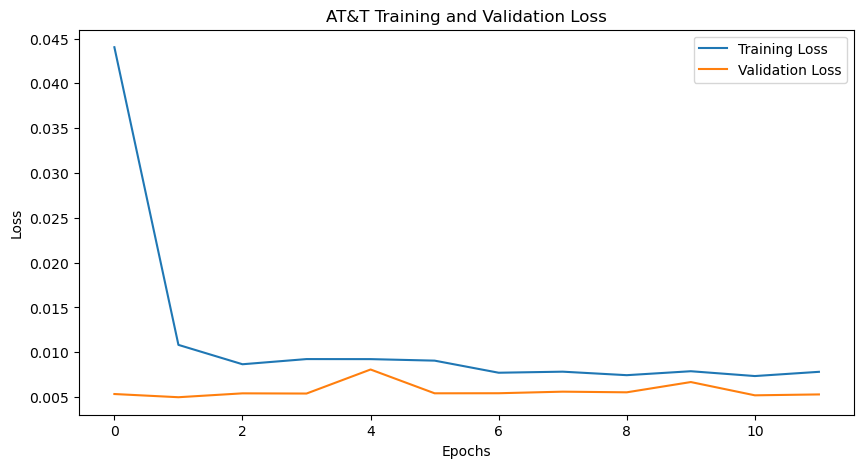

In [26]:
rnn_t = SimpleRNNModel(merged_df['t_diff'], n_steps=10, n_features=1, name='AT&T')
rnn_t.scale_split()
rnn_t.optimize(n_trials=50)
rnn_t.train()
rnn_t.plot_loss()

2/2 [==============================] - 0s 2ms/step


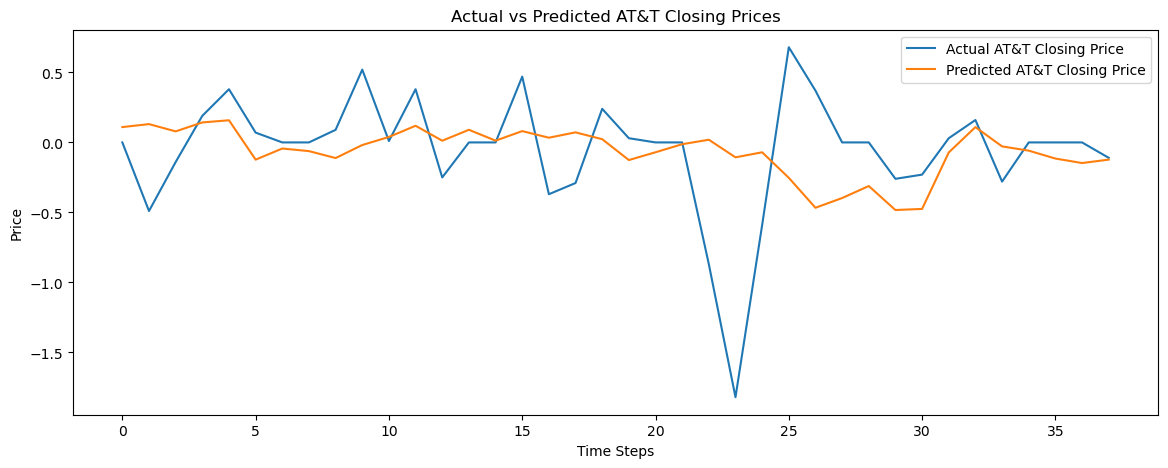

In [27]:
rnn_t.predict()
rnn_t.plot_predictions()

### Verizon Stock Price Prediction

In [72]:
def objective_v(trial):
    # Define the hyperparameter search space
    n_units = trial.suggest_int("n_units", 20, 200)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    window_size = trial.suggest_int("window_size", 5, 30)

    # Re-create the dataset with the current window_size
    X_train, y_train = create_dataset(v_train_data, window_size)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    X_val, y_val = create_dataset(v_test_data, window_size)
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # Build the model
    model = Sequential()
    model.add(SimpleRNN(units=n_units, activation="tanh", input_shape=(window_size, 1)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1))

    # Compile the model
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mean_squared_error")

    # Define Early Stopping
    early_stop = EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, TFKerasPruningCallback(trial, "val_loss")],
        verbose=0,
    )

    # Evaluate the model on validation data
    val_loss = history.history["val_loss"][-1]

    return val_loss

In [73]:
# Create the Optuna study for Verizon
study_v = optuna.create_study(
    direction="minimize", study_name="SimpleRNN_V Hyperparameter Optimization"
)
study_v.optimize(objective_v, n_trials=50, timeout=600)  # Adjust as needed

# Display the best trial for Verizon
print("Number of finished trials for Verizon: ", len(study_v.trials))
print("Best trial for Verizon:")
trial_v = study_v.best_trial

print("  Value: {}".format(trial_v.value))
print("  Params: ")
for key, value in trial_v.params.items():
    print("    {}: {}".format(key, value))

[I 2025-01-16 22:11:06,360] A new study created in memory with name: SimpleRNN_V Hyperparameter Optimization
[I 2025-01-16 22:11:11,297] Trial 0 finished with value: 0.003017967799678445 and parameters: {'n_units': 68, 'dropout_rate': 0.18210452457255444, 'learning_rate': 1.9289802229857107e-05, 'batch_size': 16, 'window_size': 5}. Best is trial 0 with value: 0.003017967799678445.
[I 2025-01-16 22:11:15,119] Trial 1 finished with value: 0.0032533735502511263 and parameters: {'n_units': 195, 'dropout_rate': 0.10936504888453835, 'learning_rate': 0.0004157840491054802, 'batch_size': 16, 'window_size': 22}. Best is trial 0 with value: 0.003017967799678445.
[I 2025-01-16 22:11:17,063] Trial 2 finished with value: 0.0014373167650774121 and parameters: {'n_units': 72, 'dropout_rate': 0.21422405310193854, 'learning_rate': 0.0011544444308668736, 'batch_size': 128, 'window_size': 30}. Best is trial 2 with value: 0.0014373167650774121.
[I 2025-01-16 22:11:19,169] Trial 3 finished with value: 0.00

Number of finished trials for Verizon:  50
Best trial for Verizon:
  Value: 0.0013337725540623069
  Params: 
    n_units: 198
    dropout_rate: 0.13695913109987162
    learning_rate: 0.00019947646408335145
    batch_size: 16
    window_size: 30


In [74]:
# Retrieve best hyperparameters
best_params = study_v.best_trial.params

# Extract hyperparameters
best_n_units = best_params["n_units"]
best_dropout_rate = best_params["dropout_rate"]
best_learning_rate = best_params["learning_rate"]
best_batch_size = best_params["batch_size"]
best_window_size = best_params["window_size"]

# Prepare the dataset with the best window size
X_train_best, y_train_best = create_dataset(t_train_data, best_window_size)
X_train_best = X_train_best.reshape((X_train_best.shape[0], X_train_best.shape[1], 1))

X_val_best, y_val_best = create_dataset(t_test_data, best_window_size)
X_val_best = X_val_best.reshape((X_val_best.shape[0], X_val_best.shape[1], 1))

# Build the final model with best hyperparameters
final_model = Sequential()
final_model.add(
    SimpleRNN(units=best_n_units, activation="tanh", input_shape=(best_window_size, 1))
)
final_model.add(Dropout(rate=best_dropout_rate))
final_model.add(Dense(1))

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=best_learning_rate)
final_model.compile(optimizer=optimizer, loss="mean_squared_error")

# Define Early Stopping
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the final model
history = final_model.fit(
    X_train_best,
    y_train_best,
    epochs=100,
    batch_size=best_batch_size,
    validation_data=(X_val_best, y_val_best),
    callbacks=[early_stop],
    verbose=1,
)

# Evaluate the final model
test_loss = final_model.evaluate(X_val_best, y_val_best)
print(f"Final Model Test Mean Squared Error: {test_loss}")

Epoch 1/100
51/51 [==============================] - 1s 8ms/step - loss: 0.0200 - val_loss: 0.0075
Epoch 2/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0078
Epoch 3/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0076 - val_loss: 0.0072
Epoch 4/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0113
Epoch 5/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.0110
Epoch 6/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 7/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0066 - val_loss: 0.0086
Epoch 8/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 0.0093
Epoch 9/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0089
Epoch 10/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0092
Epoch 11/

1/1 [==============================] - 0s 13ms/step


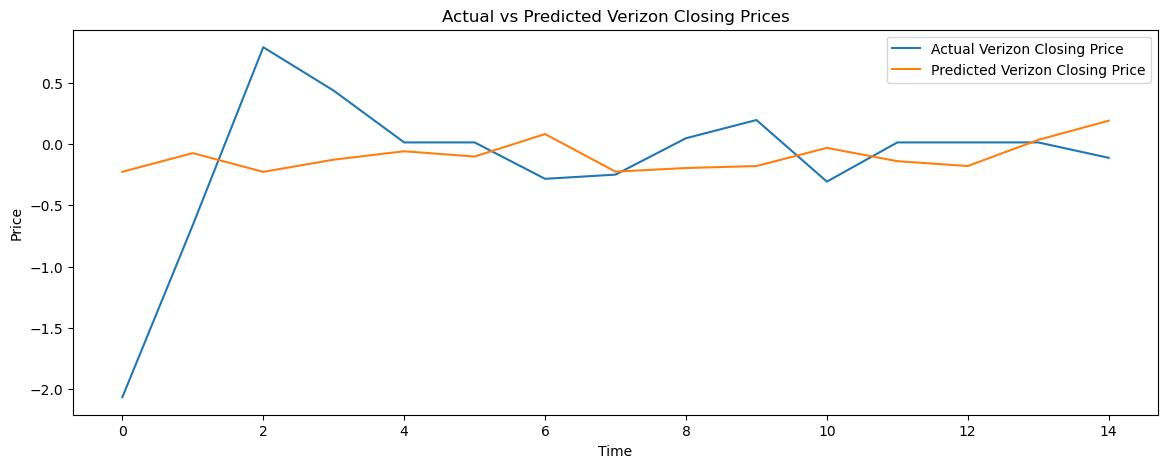

In [76]:
# Make predictions on test data
y_pred_best = final_model.predict(X_val_best)

# Inverse transform the scaled data
v_y_test_actual = scaler_v.inverse_transform(y_val_best.reshape(-1, 1))
v_y_pred_actual = scaler_v.inverse_transform(y_pred_best)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(v_y_test_actual, label="Actual Verizon Closing Price")
plt.plot(v_y_pred_actual, label="Predicted Verizon Closing Price")
plt.title("Actual vs Predicted Verizon Closing Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()